In [60]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import astropy.cosmology
from astropy.cosmology import Planck15 as cosmo
import scipy.stats
import time
from useful_funcs import PAUSflux_to_ABmag

In [3]:
# MAY NEED ADJUSTING DEPEDNING ON DEVICE/OS RUNNING
# data = pd.read_csv("../../Data/PAUS_866.csv")
# data['band'] = data['band'].str.slice(start=2).astype(int)
# Converts 'band' column from type string to int

data = pd.read_pickle("../../Data/Object_zs_zp_181120_171354.pkl.gz")

In [4]:
data.columns

Index(['ref_id_2', 'z_photo', 'z_spec', 'type', 'conf', 'n_bands', 'band0',
       'band1', 'band2', 'band3', 'band4', 'band5', 'band6', 'band7', 'band8',
       'band9', 'band10', 'band11', 'band12', 'band13', 'band14', 'band15',
       'band16', 'band17', 'band18', 'band19', 'band20', 'band21', 'band22',
       'band23', 'band24', 'band25', 'band26', 'band27', 'band28', 'band29',
       'band30', 'band31', 'band32', 'band33', 'band34', 'band35', 'band36',
       'band37', 'band38', 'band39', 'band0_flux', 'band1_flux', 'band2_flux',
       'band3_flux', 'band4_flux', 'band5_flux', 'band6_flux', 'band7_flux',
       'band8_flux', 'band9_flux', 'band10_flux', 'band11_flux', 'band12_flux',
       'band13_flux', 'band14_flux', 'band15_flux', 'band16_flux',
       'band17_flux', 'band18_flux', 'band19_flux', 'band20_flux',
       'band21_flux', 'band22_flux', 'band23_flux', 'band24_flux',
       'band25_flux', 'band26_flux', 'band27_flux', 'band28_flux',
       'band29_flux', 'band30_flux

In [5]:
# data.loc[:,['type','conf']]

# SED

In [6]:
#CUT
mask = data['conf'].astype('str').str.match('^[34]\.[0-9]$') | data['conf'].astype('str').str.match('^[29]\.5$') 

data_sample = data.loc[(data['n_bands']>=30) & mask]
# data_sample['n_bands'].unique()

In [7]:
lum_dists_1d = cosmo.luminosity_distance(data_sample['z_spec']).value
luminosity_distances = np.repeat(lum_dists_1d[:,None],40,axis=1)
# print(luminosity_distances.shape)
# bands = data['band']
z_specs = data_sample['z_spec']
# object_ids = data.loc[data['zb'].notna()]['ref_id_2']
# fluxs = data.loc[data['zb'].notna()]['flux']

#GENERATE Luminosity Distances

/home/andrew/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1019: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/andrew/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


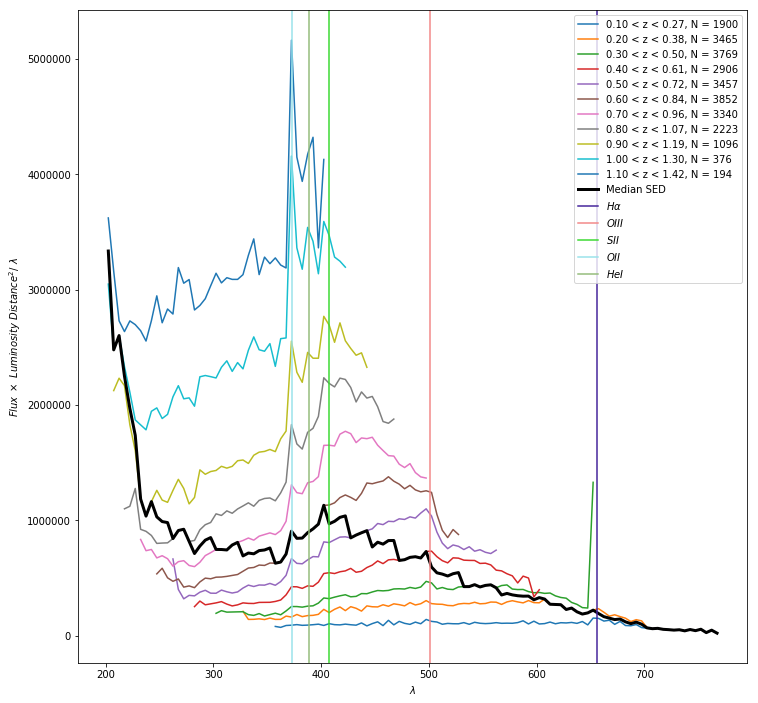

In [8]:
bins = [[0.1,0.27],[0.2,0.38],[0.3,0.5],[0.4,0.61],[0.5,0.72],[0.6,0.84],[0.7,0.96],[0.8,1.07],[0.9,1.19],[1,1.3],[1.1,1.42]]


# bins = [[0.7,0.75],[0.75,0.8],[0.8,0.85]]
fig = plt.figure(figsize=(12,12))

band_obsframe = data_sample.loc[:,'band0':'band39'].values/(data_sample['z_spec'].values[:,None]+1)
# print(band_obsframe.min(),band_obsframe.max())
band_bins = np.arange(200,860,5)

# print(band_obsframe,band_bins)
all_means = []
# print(data.loc[(data['imag']==0)|(data['rmag']==0)|(data['odds']<0)]['flux'])


for z_bin in bins:
    truth_table = (z_specs >= z_bin[0]) & (z_specs <= z_bin[1])
    lamb_sample = band_obsframe[truth_table].flatten()
    flux_sample = data_sample.loc[truth_table,'band0_flux':'band39_flux'].values.flatten()
    lum_dist_sample = luminosity_distances[truth_table].flatten()
#     print(lamb_sample.shape,flux_sample.shape,lum_dist_sample.shape)
    
#     flux_sample = 10**((26-flux_sample)/2.5) #<---- AB mag to flux conversion
    
    N_objects = band_obsframe[truth_table].shape[0]
    
    digitized = np.digitize(lamb_sample,band_bins)
    binned_means = [np.nanmedian(flux_sample[digitized == i] * lum_dist_sample[digitized == i]**2) for i in range(1,len(band_bins))]
    all_means.append(binned_means/(band_bins[1:]+band_bins[:-1])*2) #flux(in AB mags)/band wl
#     print (binned_means)
    
    plt.plot((band_bins[1:]+band_bins[:-1])/2,np.array(binned_means)/(band_bins[1:]+band_bins[:-1])*2,\
             label="{:.02f} < z < {:.02f}, N = {}".format(z_bin[0],z_bin[1],N_objects)) #flux(in AB mags)/500 band wl

# print(np.array(all_means))
plt.plot((band_bins[1:]+band_bins[:-1])/2,np.nanmedian(np.array(all_means),axis=0),'k-',linewidth=3,label="Median SED")

emis_lines = [[656.28,r'$H\alpha$'],[500.7,r'$OIII$'],[407.2,r'$SII$'],[372.8,r"$OII$"],[388.9,r'$HeI$']]
for line in emis_lines:
    random_ints = np.random.randint(256,size=3)
    plt.axvline(line[0],label=line[1],color='#{}{}{}'.\
                format(hex(random_ints[0])[2:].zfill(2),hex(random_ints[1])[2:].zfill(2),hex(random_ints[2])[2:].zfill(2)))

plt.xlabel(r'$\lambda$')
plt.ylabel(r'$Flux\ \times\ Luminosity\ Distance^2 /\ \lambda$')
plt.legend()
# plt.ylim([0,0.1])
#plt.xlim([200,680])
plt.show()


# PAUS UV 

In [29]:
# PAUS_UV = [305,365]
# PAUS_UV_z = [0.48,1.39]

# #Z Cut
# data_sample_zcut = data_sample.loc[(data_sample['z_spec']>=PAUS_UV_z[0])&(data_sample['z_spec']<=PAUS_UV_z[1])]

# band_boundaries_ = np.arange(450,851,10)
# band_boundaries_ = np.tile(band_boundaries_,(data_sample_zcut['z_spec'].size,1))
# shifted_boundaries_ = band_boundaries_ / (1+data_sample_zcut['z_spec'].values[:,None])

# mask1 = (shifted_boundaries_[:,:-1] < PAUS_UV[0]) & (shifted_boundaries_[:,1:] > PAUS_UV[0])
# # mask1a = np.append(mask1,np.repeat(np.array([False]),mask1.shape[0])[:,None],axis=1)
# mask1a = np.insert(mask1,-1,False,axis=1)
# mask1b = np.insert(mask1,0,False,axis=1)

# mask2 = (shifted_boundaries_[:,:-1] < PAUS_UV[1]) & (shifted_boundaries_[:,1:] > PAUS_UV[1])
# mask2a = np.insert(mask2,-1,False,axis=1)
# mask2b = np.insert(mask2,0,False,axis=1)
# # print(mask1.shape,mask1a.shape,mask1b.shape,shifted_boundaries_.shape)

# mask_midvals = (shifted_boundaries_ > PAUS_UV[0]) & (shifted_boundaries_ < PAUS_UV[1]) \
# #         & (np.logical_not(mask1a)) & (np.logical_not(mask1b)) & (np.logical_not(mask2a)) &\
# #         (np.logical_not(mask2b)) 


# # fluxs = 

/home/andrew/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/home/andrew/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()
/home/andrew/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
/home/andrew/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':
/home/andrew/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/home/andrew/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
/home/andrew/.local/lib/pyt

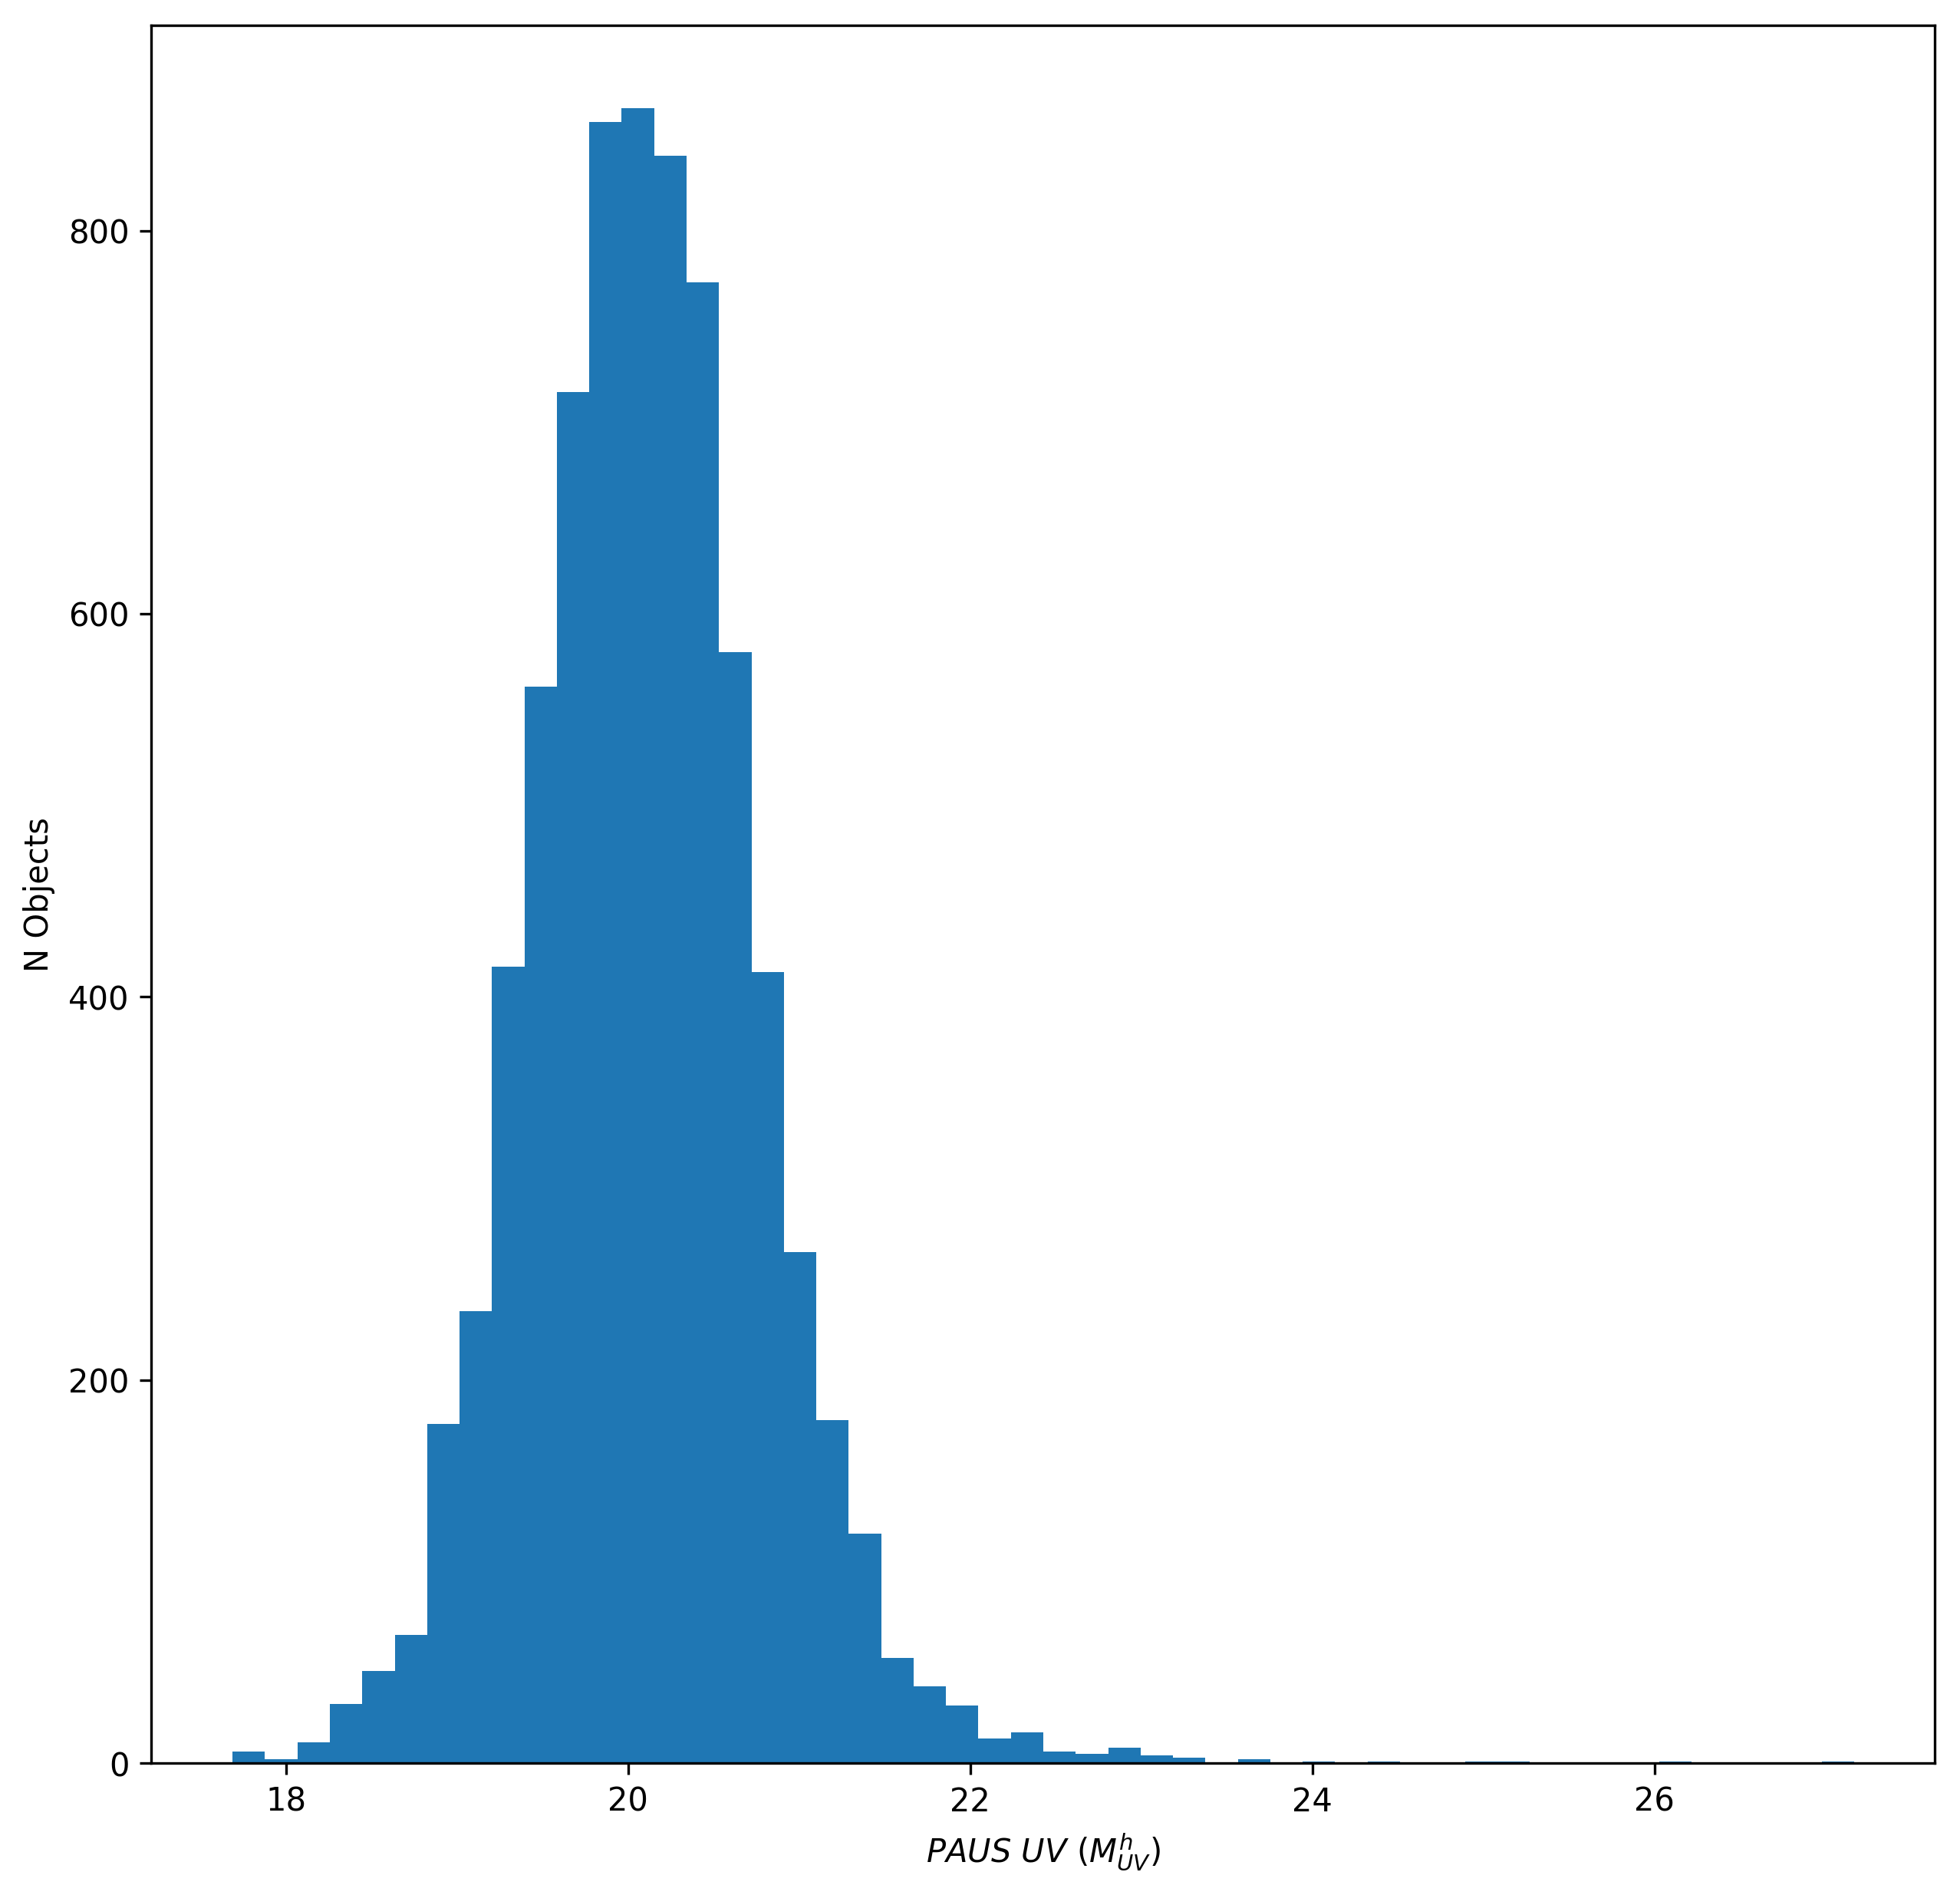

In [69]:
PAUS_UV = [305,365]
PAUS_UV_z = [0.48,1.39]

data_sample_zcut = data_sample.loc[(data_sample['z_spec']>=PAUS_UV_z[0])&(data_sample['z_spec']<=PAUS_UV_z[1])]
l_bound, r_bound = data_sample_zcut.loc[:,'band0':'band39'].values-5,data_sample_zcut.loc[:,'band0':'band39'].values+5

# for ind,i in enumerate(data_sample_zcut['ref_id_2']):
l_bound, r_bound = l_bound/(1+data_sample_zcut['z_spec'].values[:,None]),\
                    r_bound/(1+data_sample_zcut['z_spec'].values[:,None])

mask_midvals = (l_bound > PAUS_UV[0]) & (l_bound < PAUS_UV[1]) &\
                ((r_bound > PAUS_UV[0]) & (r_bound < PAUS_UV[1]))


#Left side fraction
mask_l = (l_bound < PAUS_UV[0]) & (r_bound > PAUS_UV[0])
tmp_ls = np.where(mask_l,l_bound,np.nan)
tmp_rs = np.where(mask_l,r_bound,np.nan)
flux_ls = (tmp_rs - PAUS_UV[0])/(tmp_rs-tmp_ls) * data_sample_zcut.loc[:,'band0_flux':'band39_flux'].values
np.nan_to_num(flux_ls,copy=False)


#Right side fraction
mask_r = (l_bound < PAUS_UV[1]) & (r_bound > PAUS_UV[1])
tmp_ls = np.where(mask_r,l_bound,np.nan)
tmp_rs = np.where(mask_r,r_bound,np.nan)
flux_rs = (tmp_rs - PAUS_UV[0])/(tmp_rs-tmp_ls) * data_sample_zcut.loc[:,'band0_flux':'band39_flux'].values
np.nan_to_num(flux_rs,copy=False)


fluxs = np.where(mask_midvals,data_sample_zcut.loc[:,'band0_flux':'band39_flux'].values,0)
tot_fluxs = fluxs.sum(axis=1) + flux_ls.sum(axis=1) + flux_rs.sum(axis=1)

ABmags = PAUSflux_to_ABmag(tot_fluxs)

plt.figure(figsize=(10,10),dpi=300)
plt.hist(ABmags,50)
plt.xlabel(r'$PAUS\ UV\ (M_{UV}^h)$')
plt.ylabel('N Objects')
plt.show()



